In [1]:
%cd ..

/hdd/aouadt/these/projets/3d_segm


In [132]:
# %% Morp Registration
from importlib import reload
import os

import nibabel as nib
import cv2
from time import time
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import skimage.morphology as morp
import skimage.measure as meas
from scipy.ndimage import rotate
from scipy.spatial import procrustes
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import general.utils as u
import general.array_morphology as am
import ssm.icp as icp

def reload_modules():
    for modl in [u, am, icp]:
        reload(modl)

reload_modules()

In [3]:
%matplotlib notebook

# I) Registration

In [82]:
# %%

path_segm = os.path.abspath("/hdd/datasets/CT-ORG/raw/labels_and_README/labels-4.nii.gz")
seg1n = nib.load(path_segm)
seg1 = np.round(seg1n.get_fdata()) == 2

path_segm = os.path.abspath("/hdd/datasets/CT-ORG/raw/labels_and_README/labels-5.nii.gz")
seg2n = nib.load(path_segm)
seg2 = np.round(seg2n.get_fdata()) == 2


In [83]:
%%time
reload_modules()
reg1 = (u.get_most_important_regions(seg1) > 0).astype(int)
reg2 = (u.get_most_important_regions(seg2) > 0).astype(int)



CPU times: user 22.5 s, sys: 1.07 s, total: 23.5 s
Wall time: 23.5 s


In [84]:
%%time
verts1, faces1, normals1, values1 = meas.marching_cubes(reg1, step_size=1)
verts2, faces2, normals2, values2 = meas.marching_cubes(reg2, step_size=1)



CPU times: user 3.76 s, sys: 185 ms, total: 3.95 s
Wall time: 3.94 s


<IPython.core.display.Javascript object>


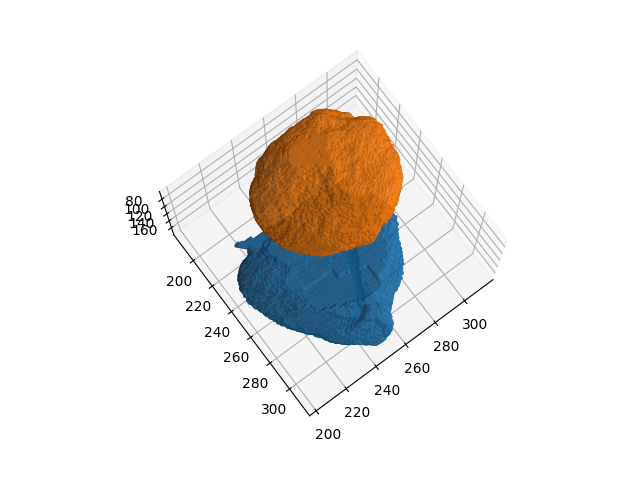

In [85]:
# %%
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_trisurf(*verts1.T, triangles=faces1)
ax.plot_trisurf(*verts2.T, triangles=faces2)


In [ ]:
# %%
u.save_as_nii(
    "segmentations/CT_ORG/labels-4-opened.nii.gz",
    reg3,
    seg3n.affine,
    dtype=np.uint8
)


In [19]:
def get_ellipse_fn(center, matrix, radius):
    def fn(*x):
        W, L, H = x[0].shape
        Z = np.zeros_like(x[0])
        for i in range(W):
            for j in range(L):
                for k in range(H):
                    coord = np.array([x[0][i, j, k], x[1][i, j, k], x[2][i, j, k]]) - center
                    coord = coord[:, np.newaxis]
                    Z[i, j, k] = np.sqrt( coord.T @ matrix @ coord) - radius
        return Z
    return fn

def get_ellipsoid_points(center, matrix, radius, shape=(40, 40, 40), eps=1e-1):

    XX, YY, ZZ = np.meshgrid(np.arange(shape[0]), np.arange(shape[1]), np.arange(shape[2]))
    fn_ellipse = get_ellipse_fn(center, matrix, radius)
    lvset = fn_ellipse(XX, YY, ZZ)
    mask = np.zeros_like(lvset)
    mask[(-eps < lvset) & (lvset < eps)] = 1
    Xs, Ys, Zs = np.where(mask)
    return np.concatenate((Xs[:, np.newaxis], Ys[:, np.newaxis], Zs[:, np.newaxis]), axis=1)


In [161]:
%%time
shape = (70, 70, 70)
eps=1e-3

A1= np.array([
    [6, 2, 1],
    [2, 2, 0],
    [1, 0, 1]
])
center1 = np.array([15, 10, 10])
radius1 = 5

ell1 = get_ellipsoid_points(center1, A1, radius1, shape=shape, eps=eps)

A2 = np.array([
    [6, 0, 0],
    [0, 2, 0],
    [0, 0, 1]
])
center2 = np.array([10, 10, 10])
radius2 = 5

ell2 = get_ellipsoid_points(center2, A2, radius2, shape=shape, eps=eps)

CPU times: user 2.93 s, sys: 10.1 ms, total: 2.94 s
Wall time: 2.94 s


<IPython.core.display.Javascript object>


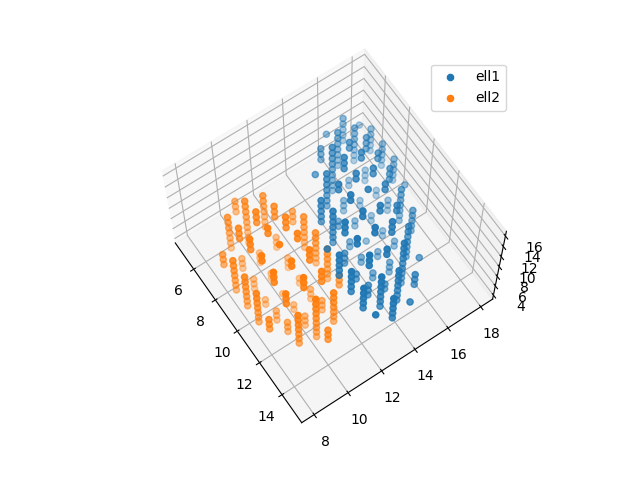

In [162]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(*ell1.T, label='ell1')
ax.scatter(*ell2.T, label='ell2')
ax.legend()

In [91]:
%%timeit
reload_modules()
T, errs, iters = icp.icp(ell1, ell2, n_points=20)


11.7 ms ± 108 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [151]:
all_errs = []
all_errs2 = []
all_n_points = range(1, len(ell1))
T_opt = np.array([
    [1, 0, 0, 0],
    [0, 1, 0, -5],
    [0, 0, 1, 0],
    [0, 0, 0, 1]
])

for n_pt in tqdm(all_n_points):
    T, errs ,iters = icp.icp(ell1, ell2, n_points=n_pt, max_iterations=1000)
    all_errs.append(np.abs(errs).max())
    all_errs2.append(np.max(T - T_opt))

100%|██████████| 183/183 [00:12<00:00, 15.09it/s]


<IPython.core.display.Javascript object>


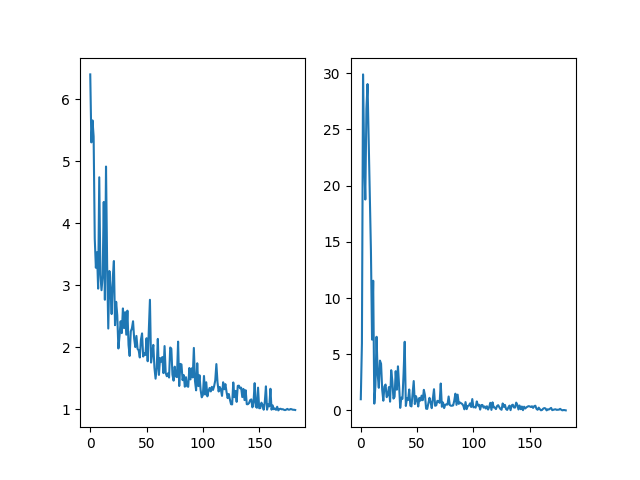

In [152]:
fig, axs = plt.subplots(1, 2)
axs[0].plot(all_errs)
axs[1].plot(all_errs2)

In [121]:
print(T)
print(np.abs(errs).mean())
print(iters)

[[ 1.00000000e+00 -9.90796275e-07 -1.41774147e-06  2.90207983e-05]
 [ 9.89326211e-07  9.99999463e-01 -1.03653054e-03 -4.98964221e+00]
 [ 1.41876770e-06  1.03653054e-03  9.99999463e-01 -2.10099371e-02]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]
0.011818425868727712
7


In [163]:
reload_modules()
T, errs, iters = icp.icp(ell1, ell2)
print(T)
print(np.abs(errs).max())
print(iters)

[[ 0.89959054 -0.31147948 -0.30613296  8.77730865]
 [ 0.37209864  0.91361427  0.16386447 -9.0799491 ]
 [ 0.22864702 -0.26132259  0.93777985  2.30011588]
 [ 0.          0.          0.          1.        ]]
1.937060309529838
15


<IPython.core.display.Javascript object>


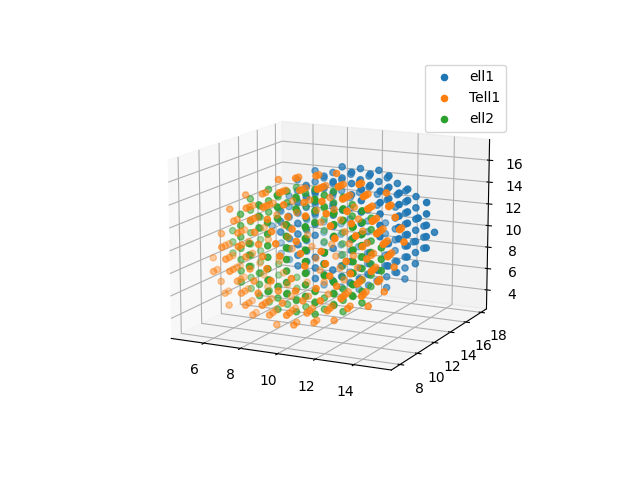

In [164]:
Tell2 = ((T @ np.hstack((ell2, np.ones((ell2.shape[0], 1)))).T).T)[:, :-1]
Tell1 = ((T @ np.hstack((ell1, np.ones((ell1.shape[0], 1)))).T).T)[:, :-1]

fig = plt.figure()
ax1 = fig.add_subplot(111, projection='3d')

ax1.scatter(*ell1.T, label='ell1')
ax1.scatter(*Tell1.T, label='Tell1')
ax1.scatter(*ell2.T, label='ell2')
ax1.legend()

In [35]:
T.shape

(4, 4)

# II) Alignment

# III) Statistics

# IV) Inference